Let's first get the imports out of the way.

In [0]:
import array
import gzip
import itertools
import numpy
import numpy.random as npr
import os
import struct
import time
from os import path
import urllib.request

import jax.numpy as np
from jax.api import jit, grad
from jax.config import config
from jax.scipy.special import logsumexp
from jax import random
import matplotlib.pyplot as plt

The following cell contains boilerplate code to download and load MNIST data.

In [2]:
_DATA = "/tmp/"

def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(create_outliers=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  test_images = _partial_flatten(test_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if create_outliers:
    mum_outliers = 30000
    perm = numpy.random.RandomState(0).permutation(mum_outliers)
    train_images[:mum_outliers] = train_images[:mum_outliers][perm]

  return train_images, train_labels, test_images, test_labels

def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels

train_images, train_labels, test_images, test_labels = mnist(create_outliers=False)
num_train = train_images.shape[0]

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/


# **Problem 1**

This function computes the output of a fully-connected neural network (i.e., multilayer perceptron) by iterating over all of its layers and:

1. taking the `activations` of the previous layer (or the input itself for the first hidden layer) to compute the `outputs` of a linear classifier. Recall the lectures: `outputs` is what we wrote $z=w\cdot x + b$ where $x$ is the input to the linear classifier. 
2. applying a non-linear activation. Here we will use $tanh$.

Complete the following cell to compute `outputs` and `activations`. 

In [0]:
def predict(params, inputs):
  activations = inputs
  for w, b in params[:-1]:  #iterate through each layer
    outputs = np.dot(activations, w) + b
    activations = np.tanh(outputs)

  final_w, final_b = params[-1]
  logits = np.dot(activations, final_w) + final_b #Return a matrix, each vector is one sample
  return logits - logsumexp(logits, axis=1, keepdims=True) #Return a matrix, contains different vectors, each vector has element with log-logsum

The following cell computes the loss of our model. Here we are using cross-entropy combined with a softmax but the implementation uses the `LogSumExp` trick for numerical stability. This is why our previous function `predict` returns the logits to which we substract the `logsumexp` of logits. We discussed this in class but you can read more about it [here](https://blog.feedly.com/tricks-of-the-trade-logsumexp/).

Complete the return line. Recall that the loss is defined as :
$$ l(X, Y) = -\frac{1}{n} \sum_{i\in 1..n}  \sum_{j\in 1.. K}y_j^{(i)} \log(f_j(x^{(i)})) = -\frac{1}{n} \sum_{i\in 1..n}  \sum_{j\in 1.. K}y_j^{(i)} \log\left(\frac{z_j^{(i)}}{\sum_{k\in 1..K}z_k^{(i)}}\right) $$
where $X$ is a matrix containing a batch of $n$ training inputs, and $Y$ a matrix containing a batch of one-hot encoded labels defined over $K$ labels. Here $z_j^{(i)}$ is the logits (i.e., input to the softmax) of the model on the example $i$ of our batch of training examples $X$.

In [0]:
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -np.mean(np.sum(preds * targets, axis=1)) #-np.mean(np.sum(preds * targets, axis=1))

The following cell defines the accuracy of our model and how to initialize its parameters. 

In [0]:
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class) #Return the % of same classes

def init_random_params(layer_sizes, rng=npr.RandomState(0)): #Layer sizes contain number of neurons in each layer
  scale = 0.1
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

The following line defines our architecture with the number of neurons contained in each fully-connected layer (the first layer has 784 neurons because MNIST images are 28*28=784 pixels and the last layer has 10 neurons because MNIST has 10 classes)

In [0]:
layer_sizes = [784, 1024, 128, 10]

The following cell creates a Python generator for our dataset. It outputs one batch of $n$ training examples at a time. 

In [0]:
batch_size = 128
num_complete_batches, leftover = divmod(num_train, batch_size) #num_train = 60000, batch_size = 128, returns quotient and remainder. 468, 96
num_batches = num_complete_batches + bool(leftover) #num_batches = 469

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train) #1-60000 randomly permutate
    for i in range(num_batches): #in range(469)
      batch_idx = perm[i * batch_size:(i + 1) * batch_size] #take 128 samples
      yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()

We are now ready to define our optimizer. Here we use mini-batch stochastic gradient descent. Complete `<w UPDATE RULE>` and `<b UPDATE RULE>` using the update rule we saw in class. Recall that `dw` is the partial derivative of the `loss` with respect to `w` and `learning_rate` is the learning rate of gradient descent. 

In [0]:
learning_rate = 0.1

@jit
def update(params, batch):
  grads = grad(loss)(params, batch)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

This is now the proper training loop for our fully-connected neural network. 

In [9]:
num_epochs = 10
params = init_random_params(layer_sizes)
for epoch in range(num_epochs):
  start_time = time.time()
  for _ in range(num_batches):
    params = update(params, next(batches)) #next() returns the next iterm from iteration
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, (train_images, train_labels))
  test_acc = accuracy(params, (test_images, test_labels))
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 3.87 sec
Training set accuracy 0.9401500225067139
Test set accuracy 0.9377000331878662
Epoch 1 in 0.46 sec
Training set accuracy 0.9592833518981934
Test set accuracy 0.95250004529953
Epoch 2 in 0.46 sec
Training set accuracy 0.9681666493415833
Test set accuracy 0.9607000350952148
Epoch 3 in 0.44 sec
Training set accuracy 0.9759166836738586
Test set accuracy 0.9663000702857971
Epoch 4 in 0.50 sec
Training set accuracy 0.9795500040054321
Test set accuracy 0.9676000475883484
Epoch 5 in 0.46 sec
Training set accuracy 0.982616662979126
Test set accuracy 0.970300018787384
Epoch 6 in 0.46 sec
Training set accuracy 0.9865833520889282
Test set accuracy 0.9716000556945801
Epoch 7 in 0.46 sec
Training set accuracy 0.9892333149909973
Test set accuracy 0.9736000299453735
Epoch 8 in 0.45 sec
Training set accuracy 0.9911666512489319
Test set accuracy 0.9741000533103943
Epoch 9 in 0.46 sec
Training set accuracy 0.992983341217041
Test set accuracy 0.9746000170707703


# **Problem 2**

Before we get started, we need to import two small libraries that contain boilerplate code for common neural network layer types and for optimizers like mini-batch SGD.

In [0]:
from jax.experimental import optimizers
from jax.experimental import stax

Here is a fully-connected neural network architecture, like the one of Problem 1, but this time defined with `stax`

In [0]:
init_random_params, predict = stax.serial(
    stax.Flatten,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(10),
)

We redefine the cross-entropy loss for this model. As done in Problem 1, complete the return line below (it's identical). 

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.mean(np.sum(preds * targets, axis=1))

Next, we define the mini-batch SGD optimizer, this time with the optimizers library in JAX. 

In [0]:
learning_rate = 0.15
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

The next cell contains our training loop, very similar to Problem 1. 

In [14]:
num_epochs = 12

key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))
opt_state = opt_init(init_params)
itercount = itertools.count()

for epoch in range(1, num_epochs + 1):
  for _ in range(num_batches):
    opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

  params = get_params(opt_state)
  test_acc = accuracy(params, shape_as_image(test_images, test_labels))
  test_loss = loss(params, shape_as_image(test_images, test_labels))
  print('Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(test_loss, 100 * test_acc))

Test set loss, accuracy (%): (0.17, 94.92)
Test set loss, accuracy (%): (0.12, 96.36)
Test set loss, accuracy (%): (0.11, 96.80)
Test set loss, accuracy (%): (0.08, 97.28)
Test set loss, accuracy (%): (0.07, 97.70)
Test set loss, accuracy (%): (0.07, 97.70)
Test set loss, accuracy (%): (0.07, 97.88)
Test set loss, accuracy (%): (0.07, 97.76)
Test set loss, accuracy (%): (0.06, 98.02)
Test set loss, accuracy (%): (0.06, 98.09)
Test set loss, accuracy (%): (0.06, 98.22)
Test set loss, accuracy (%): (0.06, 98.19)


### **Convnet**

In [0]:
init_random_params, predict = stax.serial(
    stax.Conv(out_chan=12, filter_shape=(5, 5), strides=(1, 1)),
    stax.Relu,
    stax.MaxPool(window_shape=(2, 2)),
    stax.Conv(out_chan=16, filter_shape=(5, 5), strides=(1, 1)),
    stax.Relu,
    stax.MaxPool(window_shape=(2, 2)),
    stax.Flatten,
    stax.Dense(120),
    stax.Relu,
    stax.Dense(84),
    stax.Relu,
    stax.Dense(10)
)

In [0]:
def loss(params, batch):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -np.mean(np.sum(preds * targets, axis=1))

def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class)

In [0]:
learning_rate = 0.06
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

@jit
def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

In [18]:
num_epochs = 20
batch_size = 128
test_acc_list = []
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)
def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

for runs in range(1,6):
  print('Run {}'.format(runs))
  batches = data_stream()

  key = random.PRNGKey(123)
  _, init_params = init_random_params(key, (-1, 28, 28, 1))
  opt_state = opt_init(init_params)
  itercount = itertools.count()

  for epoch in range(1, num_epochs + 1):
    for _ in range(num_batches):
      opt_state = update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

    params = get_params(opt_state)
    test_acc = accuracy(params, shape_as_image(test_images, test_labels))
    test_loss = loss(params, shape_as_image(test_images, test_labels))
    print('Epoch {} Test set loss, accuracy (%): ({:.2f}, {:.2f})'.format(epoch, test_loss, 100 * test_acc))
  test_acc_list.append(test_acc)
mean_accuracy, std_accuracy = np.mean(np.array(test_acc_list)), np.std(np.array(test_acc_list))
print('Test Set Mean Accuracy over 5 runs: {}, Standard Deviation: {}'.format(mean_accuracy, std_accuracy))

Run 1
Epoch 1 Test set loss, accuracy (%): (0.07, 97.83)
Epoch 2 Test set loss, accuracy (%): (0.04, 98.60)
Epoch 3 Test set loss, accuracy (%): (0.04, 98.88)
Epoch 4 Test set loss, accuracy (%): (0.03, 98.92)
Epoch 5 Test set loss, accuracy (%): (0.03, 98.92)
Epoch 6 Test set loss, accuracy (%): (0.03, 99.08)
Epoch 7 Test set loss, accuracy (%): (0.03, 99.06)
Epoch 8 Test set loss, accuracy (%): (0.03, 99.02)
Epoch 9 Test set loss, accuracy (%): (0.03, 99.06)
Epoch 10 Test set loss, accuracy (%): (0.03, 99.12)
Epoch 11 Test set loss, accuracy (%): (0.03, 98.91)
Epoch 12 Test set loss, accuracy (%): (0.06, 98.20)
Epoch 13 Test set loss, accuracy (%): (0.04, 98.90)
Epoch 14 Test set loss, accuracy (%): (0.04, 98.85)
Epoch 15 Test set loss, accuracy (%): (0.03, 99.13)
Epoch 16 Test set loss, accuracy (%): (0.03, 99.12)
Epoch 17 Test set loss, accuracy (%): (0.03, 99.14)
Epoch 18 Test set loss, accuracy (%): (0.03, 99.11)
Epoch 19 Test set loss, accuracy (%): (0.04, 99.09)
Epoch 20 Test s

### **Adversarial Example**

#### **1.1**

In [0]:
class_7_index = test_labels.tolist().index([0,0,0,0,0,0,0,1,0,0])
class_7_sample = test_images[class_7_index]
class_7_target = test_labels[class_7_index]
params_adv = params

In [0]:
def loss_adv(inputs, targets):
  inputs_adv, targets_adv = shape_as_image(inputs,targets)
  logits = predict(params_adv, inputs_adv)
  preds = stax.logsoftmax(logits)
  return -np.mean(np.sum(preds * targets_adv, axis=1))

In [0]:
def accuracy_adv(inputs, targets):
  inputs_adv, targets_adv = shape_as_image(inputs,targets)
  target_class = np.argmax(targets_adv, axis=1)
  predicted_class = np.argmax(predict(params_adv, inputs_adv), axis=1)
  return np.mean(predicted_class == target_class)

In [0]:
@jit
def adversarial(inputs, targets, epsilon):
  sign = np.sign(grad(loss_adv, 0)(inputs, targets))
  inputs_adv = inputs + epsilon * sign
  return inputs_adv

In [0]:
X_adv = adversarial(class_7_sample, class_7_target, 0.3)

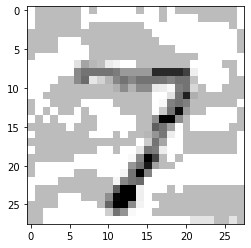

In [24]:
plt.imshow(X_adv.reshape(28,28), "Greys")
plt.show()

In [25]:
inputs_adv, targets_adv = shape_as_image(X_adv, class_7_target)
inputs_original, targets_original = shape_as_image(class_7_sample, class_7_target)
logits_adv = predict(params_adv, inputs_adv)
logits_original = predict(params_adv, inputs_original)
logits_adv_class = np.argmax(logits_adv)
logits_original_class = np.argmax(logits_original)
print('Perturbed Image Prediction Class:', logits_adv_class)
print('Perturbed Image Prediction Vector:', logits_adv)
print('')
print('Original Image Prediction Class:', logits_original_class)
print('Original Image Prediction Vector:', logits_original)

Perturbed Image Prediction Class: 9
Perturbed Image Prediction Vector: [[-2.8357334  -7.723143    0.42623523  8.071236    2.6191313   2.690835
  -8.031288   -3.440468    0.01249908 10.991759  ]]

Original Image Prediction Class: 7
Original Image Prediction Vector: [[ -6.7980375  -5.4591374  -5.331287    2.1811926   4.769041   -4.2674613
  -17.026028   18.781813   -1.3789768   4.566512 ]]


#### **1.2**

In [0]:
num_test = test_images.shape[0]
npr.seed(0)
ran_index = npr.choice(num_test, size = 1000, replace=False) #1000 random index
ran_1000_sample = test_images[ran_index]
ran_1000_target = test_labels[ran_index]

In [0]:
avg_accuracy = []
for epsilon in np.arange(0.0, 1.0, 0.01):
  X_1000_adv = adversarial(ran_1000_sample, ran_1000_target, epsilon)
  accuracy = accuracy_adv(X_1000_adv, ran_1000_target)
  avg_accuracy.append(accuracy)
epsilon_list = np.arange(0.0, 1.0, 0.01)

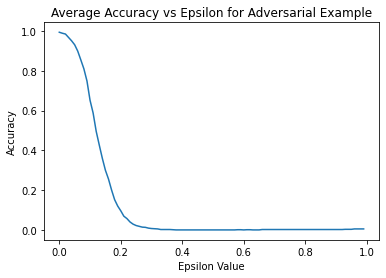

In [28]:
plt.plot(epsilon_list, avg_accuracy)
plt.xlabel('Epsilon Value')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs Epsilon for Adversarial Example')
plt.show()

#### **1.3**

In [0]:
def adversarial_revised(inputs, targets, epsilon, k):
  inputs_adv_list = []
  inputs_adv = inputs
  for i in range(k):
    sign = np.sign(grad(loss_adv, 0)(inputs_adv, targets))
    inputs_adv = inputs_adv + epsilon/k * sign
    inputs_adv_list.append(inputs_adv)
  return inputs_adv, inputs_adv_list
#jit(adversarial_revised, static_argnums=3)

Original Image Prediction Vector: [[ -6.7980375  -5.4591374  -5.331287    2.1811926   4.769041   -4.2674613
  -17.026028   18.781813   -1.3789768   4.566512 ]]
Perturbed Image Prediction Vector after 1 iterations: [[ -4.8582845  -5.529512   -4.4499054   3.2185984   5.248622   -2.3685908
  -14.893051   12.801319   -1.0406313   5.8102403]]
Perturbed Image Prediction Vector after 2 iterations: [[ -3.6839628   -5.721661    -4.928754     4.433901     4.814066
    0.02067301 -12.928602     7.171615    -1.4109999    9.582454  ]]
Perturbed Image Prediction Vector after 3 iterations: [[ -3.0068932  -6.2518663  -5.970408    5.3858147   3.9574175   1.9737016
  -11.3912325   3.1302977  -1.6996782  13.239963 ]]
Perturbed Image Prediction Vector after 4 iterations: [[ -2.0413969   -6.417049    -6.3828645    4.7672844    2.823607
    3.2959278  -10.721221     0.08200983  -1.6897302   17.004997  ]]
Perturbed Image Prediction Vector after 5 iterations: [[-2.4071589 -7.9372315 -6.013561   4.091876   2.4

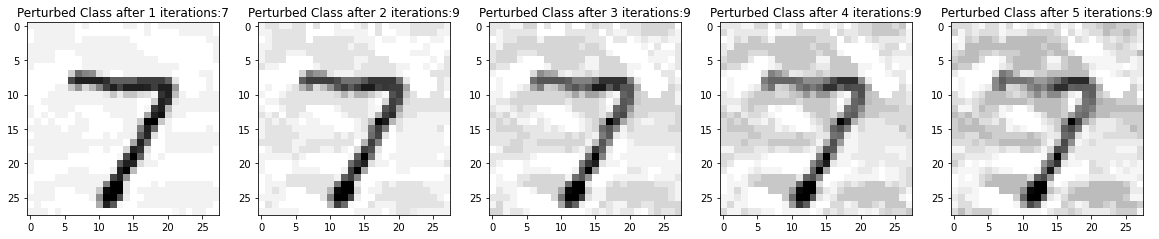

In [30]:
print('Original Image Prediction Vector:', logits_original)
plt.figure(figsize=(20, 10))
for i in range(5):
  X_adv_revised = adversarial_revised(class_7_sample, class_7_target, 0.3, 5)[1][i]
  inputs_adv_revised, targets_adv_revised = shape_as_image(X_adv_revised, class_7_target)
  logits_adv_class_revised = np.argmax(predict(params_adv, inputs_adv_revised))
  plt.subplot(1, 5, i+1)
  plt.title('Perturbed Class after {} iterations:{}'.format(i+1, logits_adv_class_revised))
  plt.imshow(X_adv_revised.reshape(28,28), "Greys")
  print('Perturbed Image Prediction Vector after {} iterations:'.format(i+1), predict(params_adv, inputs_adv_revised))

#### **1.4**

In [0]:
npr.seed(0)
ran_index_revised = npr.choice(num_test, size = 1000, replace=False) #1000 random index
ran_1000_sample_revised = test_images[ran_index]
ran_1000_target_revised = test_labels[ran_index]

In [0]:
avg_accuracy_revised = []
for epsilon in np.arange(0, 1, 0.01):
  X_1000_adv_revised = adversarial_revised(ran_1000_sample, ran_1000_target, epsilon, 5)[0]
  accuracy_revised = accuracy_adv(X_1000_adv_revised, ran_1000_target_revised)
  avg_accuracy_revised.append(accuracy_revised)
epsilon_list_revised = np.arange(0, 1, 0.01)

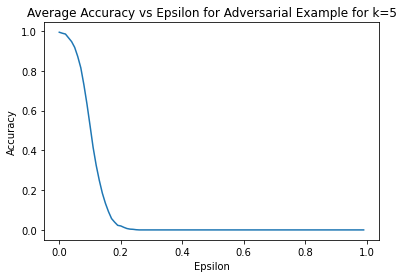

In [33]:
plt.plot(epsilon_list_revised, avg_accuracy_revised)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs Epsilon for Adversarial Example for k=5')
plt.show()